In [1]:
%matplotlib inline
import time
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
from scipy import stats
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge,Lasso,ElasticNet,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import cross_val_score
import seaborn
from IPython.display import Image

/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
file = r'Concrete_Data.xls'
data = pd.read_excel(file)

In [3]:
print(len(data))
data.head()

1030


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
#Renaming the columns
data.columns = ['cement_component', 'furnace_slag', 'flay_ash','water_component', 'superplasticizer',
                'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_strength']

In [5]:
#Correlation

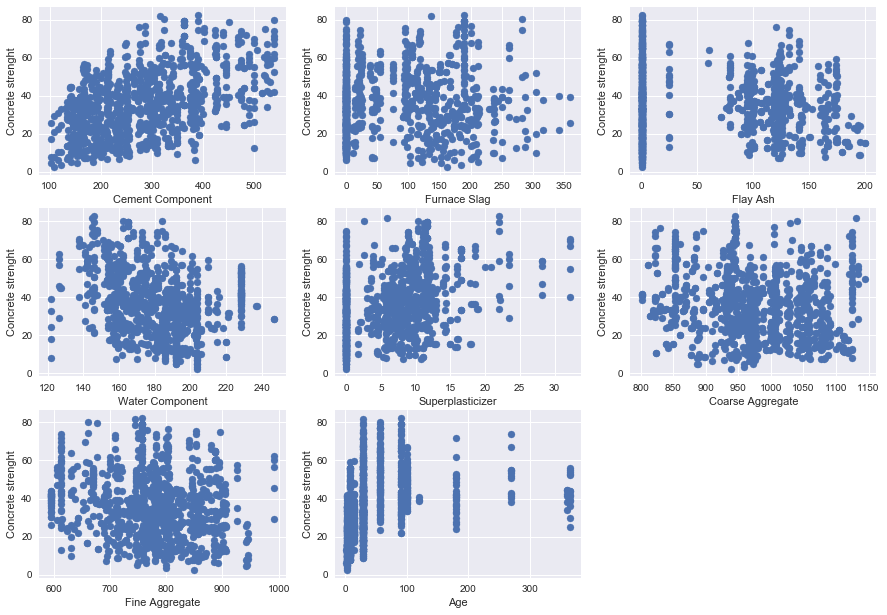

In [6]:
#Plotting Scatter Plots Between the Response and Exploratory Variables
plt.figure(figsize=(15,10.5))
plot_count = 1
for feature in list(data.columns)[:-1]:
    plt.subplot(3,3,plot_count)
    plt.scatter(data[feature], data['concrete_strength'])
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Concrete strenght')
    plot_count += 1

In [7]:
#The presence of outliers is negligible in the majority of these plots except for the plot between concrete strength and age.
#In some of the scatter plots we see a high frequency of values lying on 0. This can be seen in the plots between the concrete strength
#variable and exploratory variables, primarily age, furnace slag, fly ash, and superplasticizer.
#There seems to exist instances in which positive, sometimes negative, and sometimes no correlation exists between the two quantitative quantities.

In [8]:
#We extend these findings by listing the pairs for each of the instances

In [9]:
#Positive correlation exists between
# Cement component and concrete strength
# Superplasticizer and concrete strength
#Negative correlation lies between
# Fly ash and concrete strength
# Water component and concrete strength
# Coarse aggregate and concrete strength
# Fine aggregate and concrete strength
#No correlation exists between
# Furnace slag and concrete strength
# Age and concrete strength

In [10]:
#Calculating Pair-wise Pearson Correlations
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
correlations = data.corr(method='pearson')
print(correlations)

                   cement_component  furnace_slag  flay_ash  water_component  superplasticizer  \
cement_component              1.000        -0.275    -0.397           -0.082             0.093   
furnace_slag                 -0.275         1.000    -0.324            0.107             0.043   
flay_ash                     -0.397        -0.324     1.000           -0.257             0.377   
water_component              -0.082         0.107    -0.257            1.000            -0.657   
superplasticizer              0.093         0.043     0.377           -0.657             1.000   
coarse_aggregate             -0.109        -0.284    -0.010           -0.182            -0.266   
fine_aggregate               -0.223        -0.282     0.079           -0.451             0.223   
age                           0.082        -0.044    -0.154            0.278            -0.193   
concrete_strength             0.498         0.135    -0.106           -0.290             0.366   

                   

In [11]:
#we had assumed that there exists no correlation between age and concrete strength;
#however, the statistical results in the last graph say otherwise; 
#that is, there exists a slight positive correlation between the two quantities.

In [12]:
#Exite there a singularity or multicollinearity in the dataset?

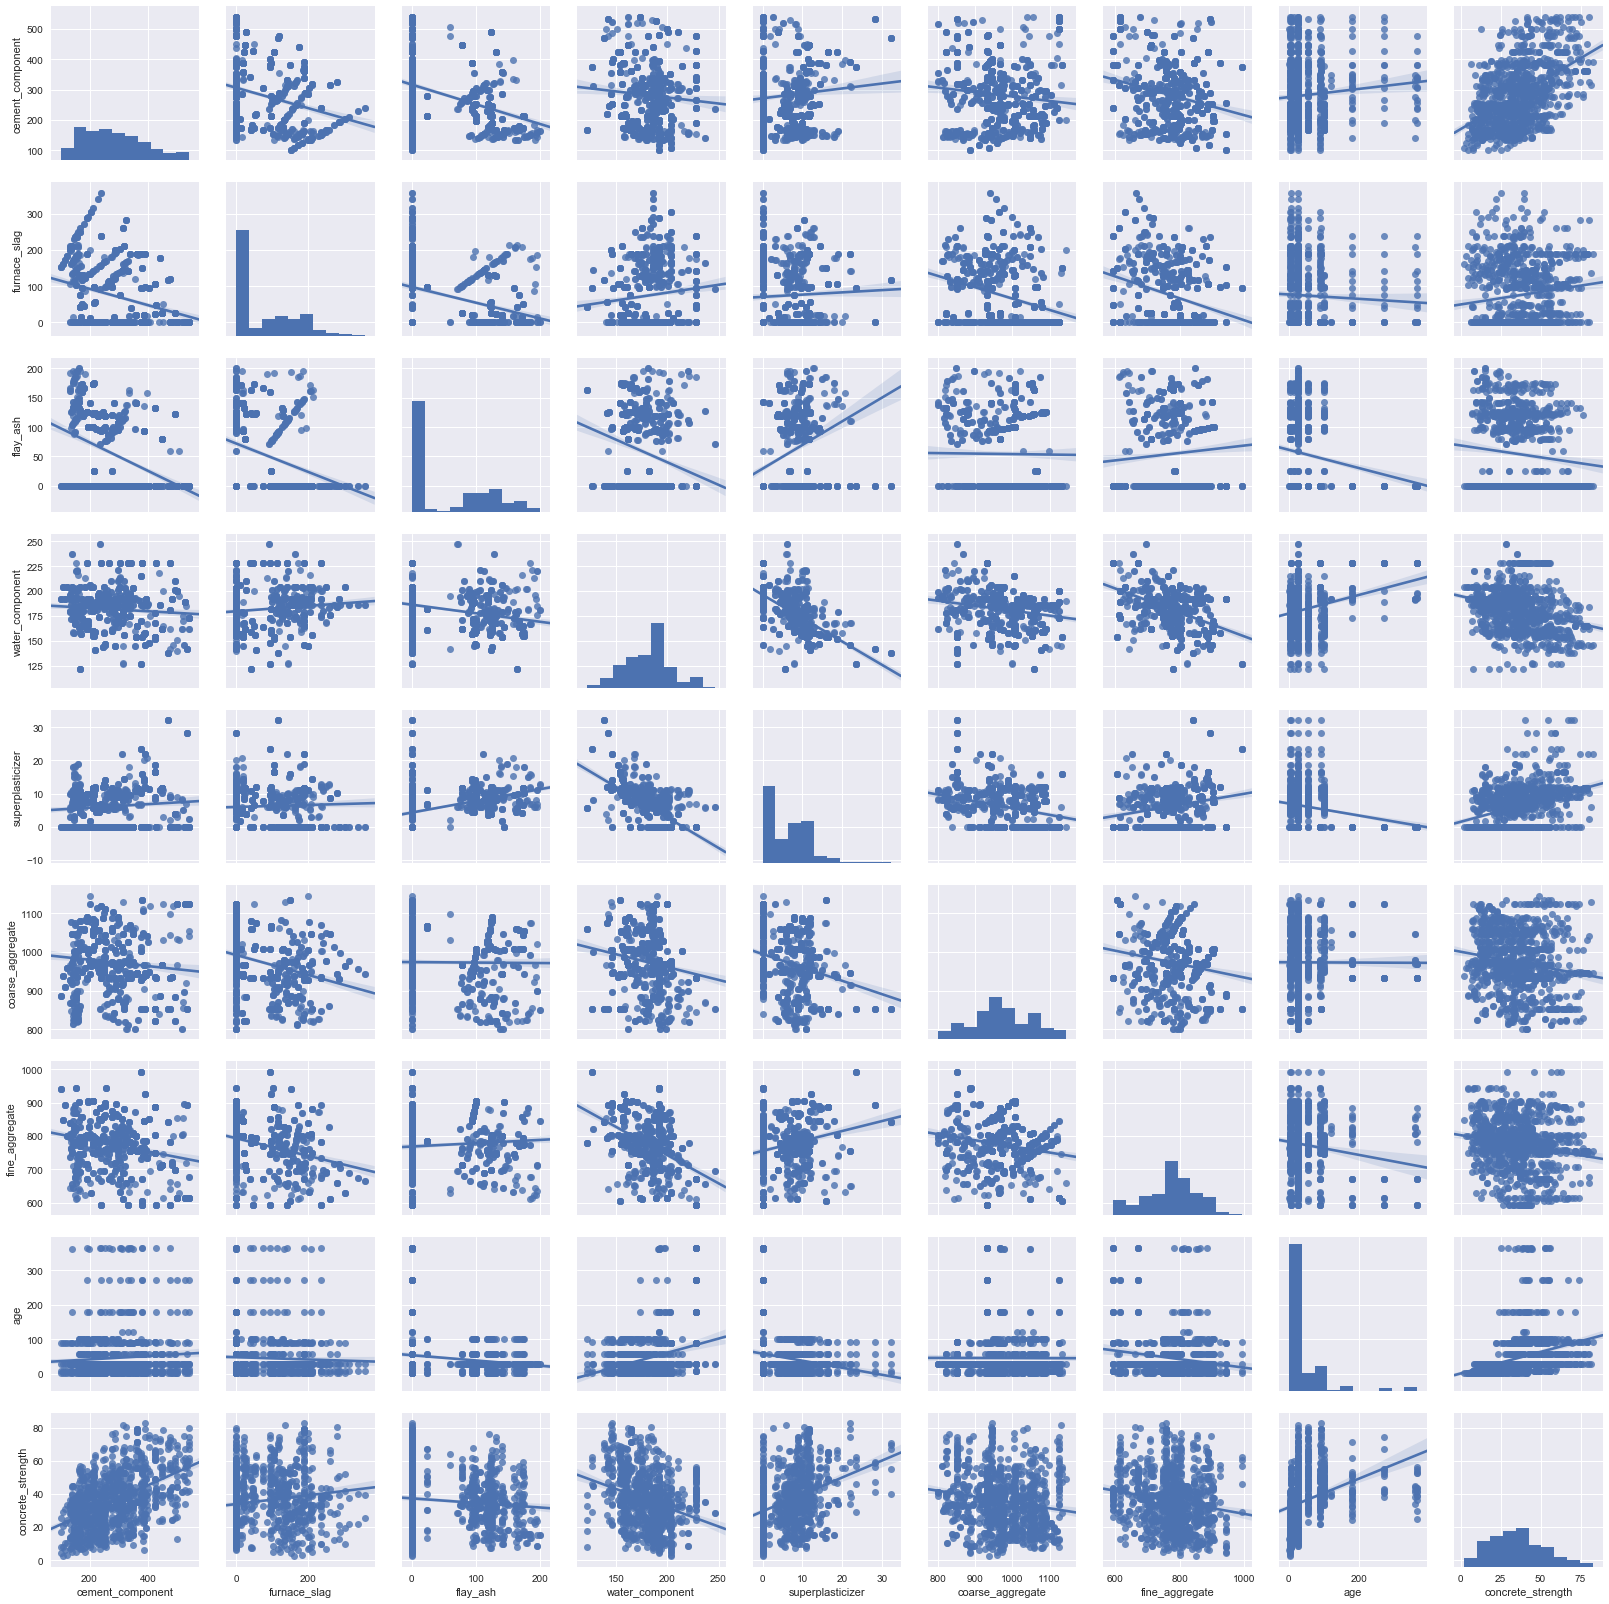

In [13]:
#Calculating Pair Plot Between All Features
data_ = data[(data.T != 0).any()] #deleting the records in columns having a value of 0.
seaborn.pairplot(data_, vars=data.columns, kind='reg')

In [14]:
#Splitting the Data in Training and Testing sets
def split_train_test(data, feature, train_index=0.7):
    train, test = train_test_split(data, test_size = 1-train_index)
    
    if type(feature) == list:
        x_train = train[feature].as_matrix()
        y_train = train['concrete_strength'].as_matrix()
        x_test = test[feature].as_matrix()
        y_test = test['concrete_strength'].as_matrix()
    else:
        x_train = [[x] for x in list(train[feature])]
        y_train = [[x] for x in list(train['concrete_strength'])]
        x_test = [[x] for x in list(test[feature])]
        y_test = [[x] for x in list(test['concrete_strength'])]
        
    return x_train, y_train, x_test, y_test

cement_component 0.289396229154
flay_ash 0.0803291347751
water_component 0.109158784447
superplasticizer 0.0818218587633
coarse_aggregate 0.0389743034244


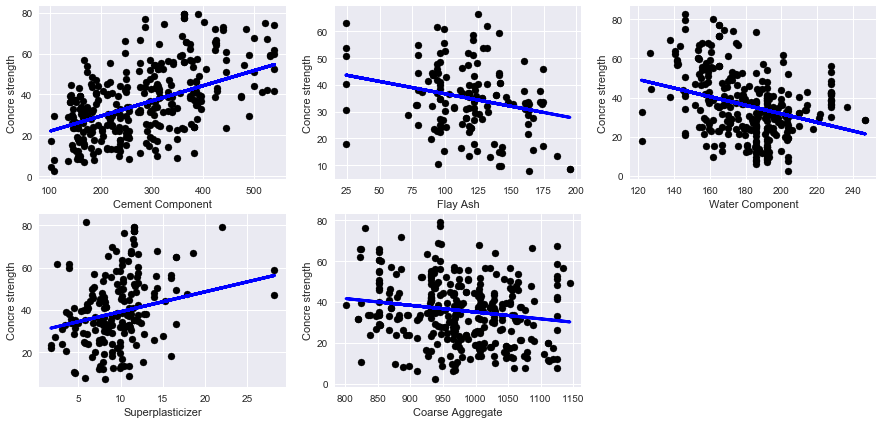

In [15]:
#Calculating Single Linear Regression
#we are only using the exploratory variables in which we noticed either positive or negative correlations
plt.figure(figsize=(15,7))
plot_count=1
for feature in ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr = data_tr[(data_tr.T != 0).all()]
    
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
    #Creating linear regression object
    regr = LinearRegression()
    
    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    
    # Plot outputs
    plt.subplot(2, 3, plot_count)
    
    plt.scatter(x_test, y_test, color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Concre strength')
    
    print(feature, r2_score(y_test, y_pred))
    
    plot_count +=1
    
plt.show()

In [16]:
#Almost all of the exploratory variables have their R 2 values closer to 0, which indicates that the linear 
#regression best fit line failed to capture the variance that lay within each of these.
#However, an exception lies in the case of the cement component, which has a relatively
#decent variance captured by its best fit line. Considering that the R 2 is low, neither of the
#models can be used for predicting concrete strength.

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.098600
Coefficients: [ 0.04686917 -0.04557107 -0.14386897  0.53041397 -0.01676738]


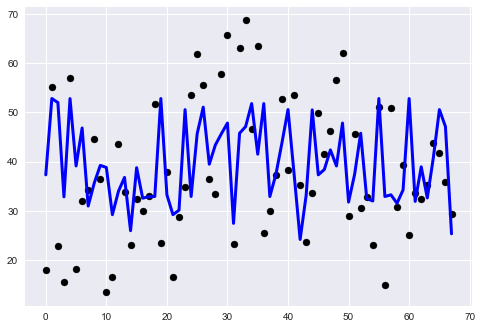

In [28]:
#Calculating Multiple Linear Regression
features = ['cement_component', 'flay_ash', 'water_component','superplasticizer', 'coarse_aggregate']
data_tr = data
data_tr=data_tr[(data_tr.T != 0).all()]

x_train, y_train, x_test, y_test = split_train_test(data_tr, features)

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)
plt.scatter(range(len(y_test)), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: %s' %str(features))
print('R2 score: %f' %r2_score(y_test, y_pred))
print('Coefficients: %s' %str(regr.coef_))

In [29]:
#the R 2 is extremely low; hence we will definitely not go forward with this

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.098605
Intercept: 68.887824
Coefficients: [ 0.04686917 -0.04557107 -0.14386897  0.53041397 -0.01676738]


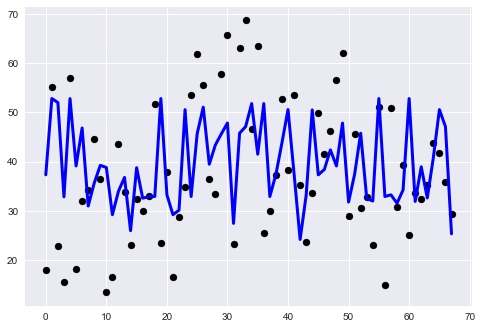

In [30]:
#Calculating Multiple Ridge Regression
alphas = np.arange(0.1, 5, 0.1)
model = Ridge()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

y_pred = cv.fit(x_train, y_train).predict(x_test)

plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: %s' %str(features))
print('R2 score: %f' %r2_score(y_test, y_pred))
print('Intercept: %f' %regr.intercept_)
print('Coefficients: %s' %str(regr.coef_))

In [31]:
#Ridge regression even after parameter didn’t bring any improvement over what a multiple linear regression had to offer.

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.099906
Intercept: 68.887824
Coefficients: [ 0.04686917 -0.04557107 -0.14386897  0.53041397 -0.01676738]


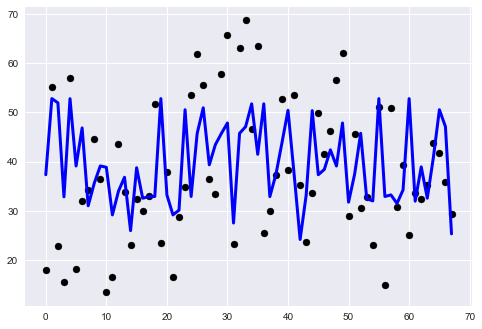

In [32]:
#Calculating Multiple Lasso Regression
model = Lasso()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
y_pred = cv.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)
print('Features: %s' %str(features))
print('R2 score: %f' %r2_score(y_test, y_pred))
print('Intercept: %f' %regr.intercept_)
print('Coefficients: %s' %str(regr.coef_))

In [33]:
#Lasso regression fared better than multiple Ridge and linear regressions
#R 2 of 0.1 is very low and not something the response variable can be extrapolated onto.

Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.099597
Intercept: 68.887824
Coefficients: [ 0.04686917 -0.04557107 -0.14386897  0.53041397 -0.01676738]


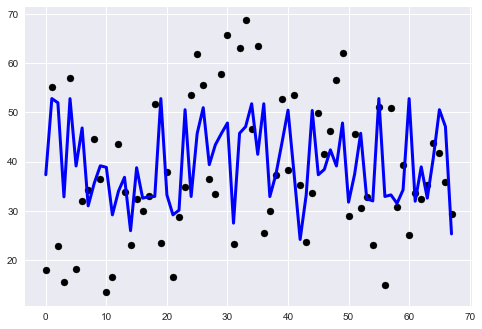

In [34]:
#Calculating Multiple ElasticNet Regression
model = ElasticNet()

cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
y_pred = cv.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: %s' %str(features))
print('R2 score: %f' %r2_score(y_test, y_pred))
print('Intercept: %f' %regr.intercept_)
print('Coefficients: %s' %str(regr.coef_))

In [35]:
#The cross-validation seemed to be lower here as compared to Lasso regression.

/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cement_component 0.319155183812
flay_ash 0.058551924984
water_component 0.238079472299
superplasticizer 0.0847774790407
coarse_aggregate 0.131259638248


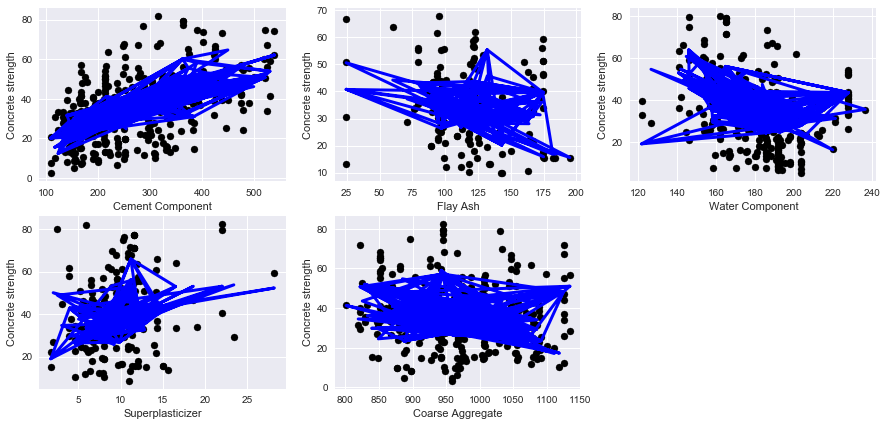

In [50]:
#Calculating Single Gradient Boosting Regression
plt.figure(figsize=(15,7))
plot_count = 1
for feature in ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
    
    # Create linear regression object
    regr = GradientBoostingRegressor()
    
    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    
    # Plot outputs
    plt.subplot(2,3,plot_count)
    
    plt.scatter(x_test, y_test,  color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')
    print(feature, r2_score(y_test, y_pred))
    plot_count+=1
    
plt.show()

In [51]:
#While looking at the R 2 coefficient values of cement component, water component,
#and coarse aggregate, we can see a better R 2 relative to what they had gotten from linear regression.

/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.131260


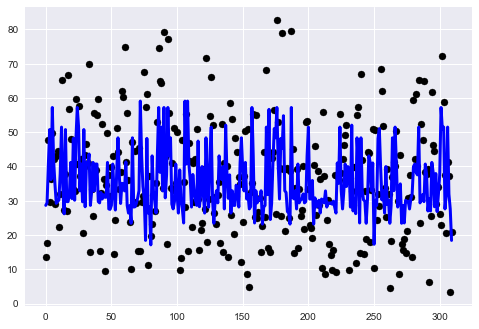

In [52]:
#Calculating Multiple Gradient Boosting Regression

model = GradientBoostingRegressor()
y_pred = model.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: %s' %str(features))
print('R2 score: %f' %r2_score(y_test, y_pred))
#print('Intercept: %f'% regr.intercept_)
#print('Coefficients: %s' %str(regr.coef_))

/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cement_component 0.274481730275
flay_ash -0.0486633127203
water_component 0.074139608876
superplasticizer 0.0741636177068
coarse_aggregate 0.0313959198116


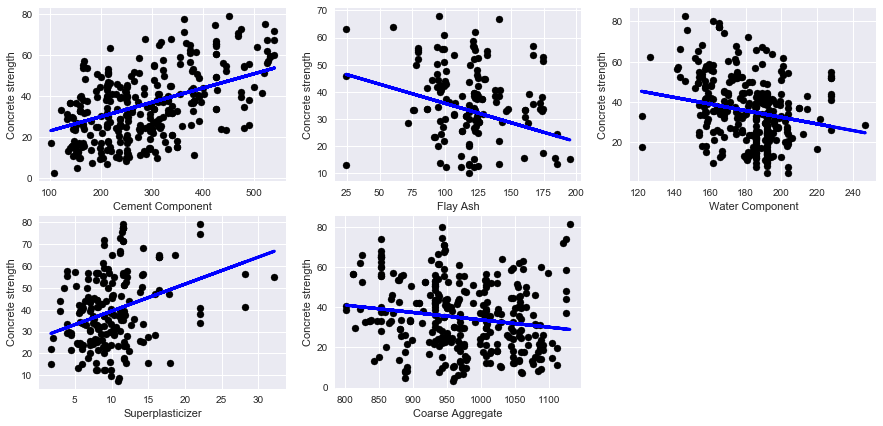

In [53]:
#Calculating Single Support Vector Machine Regression Using Linear Kernel

plt.figure(figsize=(15,7))
plot_count = 1
for feature in ['cement_component', 'flay_ash', 'water_component','superplasticizer', 'coarse_aggregate']:
    data_tr = data[['concrete_strength', feature]]
    data_tr=data_tr[(data_tr.T != 0).all()]
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
    # Create linear regression object
    regr = SVR(kernel='linear')
    # Train the model using the training sets
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    # Plot outputs
    plt.subplot(2,3,plot_count)
    
    plt.scatter(x_test, y_test,  color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_',' ').title())
    plt.ylabel('Concrete strength')
    print (feature, r2_score(y_test, y_pred))
    plot_count+=1
plt.show()

In [54]:
#the R 2 got a hit as it decreased from what they observed in single gradient boosting regressor

In [55]:
#Calculating Multiple Support Vector Machine Regression Using Linear Kernel

/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features: ['cement_component', 'flay_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2 score: 0.031396


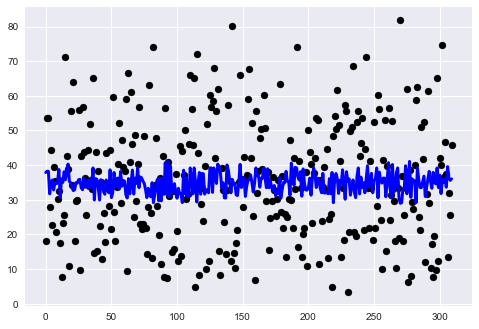

In [56]:
model = SVR(kernel='linear')
y_pred = model.fit(x_train, y_train).predict(x_test)
plt.scatter(range(len(y_test)), y_test,  color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: %s'%str(features))
print('R2 score: %f'%r2_score(y_test, y_pred))

In [57]:
#the support vector regressor performed the worst among the models we had explored earlier.

In [58]:
#other kernel types can be put into practice to increase the efficiency of the predictions.

In [59]:
#Predicting Concrete Strength from Cement Component
feature = 'cement_component'
cc_new_data = [213.58]

data_tr = data[['concrete_strength', feature]]
data_tr=data_tr[(data_tr.T != 0).all()]

x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
regr = GradientBoostingRegressor()

# Train the model using the training sets
regr.fit(x_train, y_train)
cs_pred = regr.predict(cc_new_data)
print('Predicted value of concrete strength: %f'%cs_pred)

Predicted value of concrete strength: 36.065735


/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [60]:
# Predicting Concrete Strength from Water Component

feature = 'water_component'
wc_new_data = [200]
data_tr = data[['concrete_strength', feature]]
data_tr=data_tr[(data_tr.T != 0).all()]
x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
regr = GradientBoostingRegressor()

# Train the model using the training sets
regr.fit(x_train, y_train)
cs_pred = regr.predict(wc_new_data)
print('Predicted value of concrete strength: %f'%cs_pred)

Predicted value of concrete strength: 33.752584


/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [61]:
# Predicting Concrete Strength from Coarse Aggregate

feature = 'coarse_aggregate'
ca_new_data = [1000]
data_tr = data[['concrete_strength', feature]]
data_tr=data_tr[(data_tr.T != 0).all()]
x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
regr = GradientBoostingRegressor()

# Train the model using the training sets
regr.fit(x_train, y_train)
cs_pred = regr.predict(ca_new_data)

print('Predicted value of concrete strength: %f'%cs_pred)

Predicted value of concrete strength: 29.807113


/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/winner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
